# **Baseline model**

### **Descripción**

Crearemos un modelo de referencia utilizando un enfoque heurístico. El modelo se basará en el análisis de datos de este notebook

Basándome en la heurística propuesta en el EDA, sólo se necesitan 6 columnas: **"PhoneService", "MultipleLines", "InternetService", "Contract", "SeniorCitizen" y "PaymentMethod".**

Y agregaré dos reglas más debido a la alta relación de estas dos variables con no hacer Churn: **"tenure"y "MonthlyCharges"**

📚 **Import libraries**

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
from sklearn.base import BaseEstimator, ClassifierMixin  # type: ignore
from sklearn.compose import ColumnTransformer  # type: ignore
from sklearn.impute import SimpleImputer  # type: ignore
from sklearn.model_selection import (  # type: ignore
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline  # type: ignore

💾 **Cargamos los datos**

In [2]:
# configuración para que solo se muestren 2 decimales
pd.set_option("display.float_format", "{:.2f}".format)

BASE_DIR = Path("/home/lof/Projects/Telco-Customer-Churn")
DATA_DIR = BASE_DIR / "data" / "interim"
churn_df = pd.read_parquet(DATA_DIR / "churn_type_fixed.parquet", engine="pyarrow")

👷 **Data preparation**

In [3]:
cols_boolean = [
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
    "Churn",
]
churn_df[cols_boolean] = churn_df[cols_boolean].astype("category")
cols_categoric = [
    "StreamingMovies",
    "InternetService",
    "StreamingTV",
    "OnlineSecurity",
    "MultipleLines",
    "DeviceProtection",
    "TechSupport",
    "gender ",
    "OnlineBackup",
    "PaymentMethod",
    "Contract",
]
churn_df[cols_categoric] = churn_df[cols_categoric].astype("category")

churn_df.drop_duplicates(inplace=True, keep="first")

In [4]:
selected_features = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "Contract",
    "SeniorCitizen",
    "PaymentMethod",
    "Churn",
    "tenure",
    "MonthlyCharges",
]

churn_features = churn_df[selected_features]

churn_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6917 entries, 0 to 11361
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PhoneService     6841 non-null   category
 1   MultipleLines    6825 non-null   category
 2   InternetService  6804 non-null   category
 3   Contract         6833 non-null   category
 4   SeniorCitizen    6891 non-null   category
 5   PaymentMethod    6832 non-null   category
 6   Churn            6866 non-null   category
 7   tenure           6856 non-null   float64 
 8   MonthlyCharges   6841 non-null   float64 
dtypes: category(7), float64(2)
memory usage: 210.4 KB


In [5]:
churn_features.isna().sum()

PhoneService        76
MultipleLines       92
InternetService    113
Contract            84
SeniorCitizen       26
PaymentMethod       85
Churn               51
tenure              61
MonthlyCharges      76
dtype: int64

Eliminar los duplicados, si los hay en el dataset, es importante para evitar cualquier sesgo en el conjunto de datos o data leakage cuando se entrena un modelo de aprendizaje automático con los datos.

Pero para un modelo heurístico, los duplicados no afectan al modelo.

In [6]:
len(churn_features.drop_duplicates())

6758

Después de seleccionar sólo 8 columnas hay un montón de duplicados, luego, más columnas se seleccionan y la probabilidad de duplicados es menor.

In [7]:
churn_features.sample(10, random_state=42)

,PhoneService,MultipleLines,InternetService,Contract,SeniorCitizen,PaymentMethod,Churn,tenure,MonthlyCharges
557,1.00,Yes,Fiber optic,Month-to-month,0.00,Electronic check,1.00,30.00,94.40
6938,1.00,No,Fiber optic,Month-to-month,0.00,Credit card (automatic),0.00,5.00,69.95
6020,1.00,No,No,Month-to-month,0.00,Mailed check,1.00,9.00,20.25
3170,1.00,Yes,Fiber optic,Month-to-month,0.00,Bank transfer (automatic),1.00,48.00,107.40
7947,1.00,Yes,Fiber optic,Month-to-month,0.00,Credit card (automatic),0.00,34.00,90.05
4947,1.00,No,No,One year,0.00,Credit card (automatic),0.00,61.00,19.10
4304,0.00,No phone service,DSL,Month-to-month,0.00,Mailed check,0.00,1.00,35.90
4854,1.00,No,DSL,Month-to-month,0.00,Mailed check,0.00,6.00,45.65
6141,1.00,No,No,Two year,0.00,Bank transfer (automatic),0.00,69.00,19.75
444,1.00,Yes,Fiber optic,Month-to-month,1.00,Bank transfer (automatic),0.00,35.00,102.05


👨‍🏭 **Feature Engineering**

In [8]:
cols_numeric = ["tenure", "MonthlyCharges"]
cols_categoric = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "Contract",
    "SeniorCitizen",
    "PaymentMethod",
]

In [ ]:
# Definir constantes para los valores límites
MAX_MONTHLY_CHARGE = 500
MIN_MONTHLY_CHARGE = 0


def replace_out_of_range_values(X: pd.DataFrame) -> pd.DataFrame:
    """
    Reemplaza valores fuera de rango en las columnas 'MonthlyCharges' y 'TotalCharges' con np.nan.
    """
    assert isinstance(X, pd.DataFrame)
    mask = ~(
        (X["MonthlyCharges"] > MIN_MONTHLY_CHARGE) & (X["MonthlyCharges"] < MAX_MONTHLY_CHARGE)
    )
    X.loc[mask, "MonthlyCharges"] = np.nan
    return X


def replace_invalid_values(X: pd.DataFrame) -> pd.DataFrame:
    """
    Reemplaza valores incorrectos en columnas específicas con np.nan.
    También convierte columnas específicas al tipo 'category'.
    """
    assert isinstance(X, pd.DataFrame)

    # Reemplazar valores inválidos
    invalid_values = {
        "StreamingTV": "5412335",
        "StreamingMovies": "1523434",
        "MultipleLines": "1244132",
        "DeviceProtection": "1243524",
    }
    X = X.astype(str).replace(invalid_values, np.nan)

    # Definir columnas a convertir a tipo 'category'
    cols_boolean = [
        "SeniorCitizen",
        "Partner",
        "Dependents",
        "PhoneService",
        "PaperlessBilling",
        "Churn",
    ]
    cols_categoric = [
        "StreamingMovies",
        "InternetService",
        "StreamingTV",
        "OnlineSecurity",
        "MultipleLines",
        "DeviceProtection",
        "TechSupport",
        "gender",
        "OnlineBackup",
        "PaymentMethod",
        "Contract",
    ]

    # Convertir a tipo 'category' solo si existen en el DataFrame
    existing_cols_boolean = [col for col in cols_boolean if col in X.columns]
    existing_cols_categoric = [col for col in cols_categoric if col in X.columns]

    X[existing_cols_boolean] = X[existing_cols_boolean].astype("category")
    X[existing_cols_categoric] = X[existing_cols_categoric].astype("category")

    return X

In [10]:
from sklearn.impute import KNNImputer  # type: ignore
from sklearn.pipeline import FunctionTransformer  # type: ignore
from sklearn.preprocessing import OneHotEncoder  # type: ignore

# Para esta heuristica no se necesita escalar las variables numericas
# Tampoco se neecesita codificar las variables categoricas con el onehot encoder
# Se crean dos pipelines, uno para las variables numericas y otro para las categoricas
numeric_pipe = Pipeline(
    steps=[
        (
            "outlier_removal",
            FunctionTransformer(replace_out_of_range_values, validate=False),
        ),
        ("imputer", KNNImputer(n_neighbors=5)),
    ]
)

categorical_pipe = Pipeline(
    steps=[
        (
            "clean_categories",
            FunctionTransformer(replace_invalid_values, validate=False),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # ⬅️ Aquí
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("numericas", numeric_pipe, cols_numeric),
        ("categoricas nominales", categorical_pipe, cols_categoric),
    ]
)

In [11]:
preprocessor

ColumnTransformer(transformers=[('numericas',
                                 Pipeline(steps=[('outlier_removal',
                                                  FunctionTransformer(func=<function replace_out_of_range_values at 0x7f05d0361e40>)),
                                                 ('imputer', KNNImputer())]),
                                 ['tenure', 'MonthlyCharges']),
                                ('categoricas nominales',
                                 Pipeline(steps=[('clean_categories',
                                                  FunctionTransformer(func=<function replace_invalid_values at 0x7f05d0361ee0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['PhoneService', 'MultipleLines',
                                  'InternetService', 'Contract',
                                  'SeniorCitizen', 'PaymentMethod'])])

**Ejemplo de data preprocessing**

In [12]:
data_example = churn_features.drop(columns="Churn").sample(10, random_state=42)
data_example

,PhoneService,MultipleLines,InternetService,Contract,SeniorCitizen,PaymentMethod,tenure,MonthlyCharges
557,1.00,Yes,Fiber optic,Month-to-month,0.00,Electronic check,30.00,94.40
6938,1.00,No,Fiber optic,Month-to-month,0.00,Credit card (automatic),5.00,69.95
6020,1.00,No,No,Month-to-month,0.00,Mailed check,9.00,20.25
3170,1.00,Yes,Fiber optic,Month-to-month,0.00,Bank transfer (automatic),48.00,107.40
7947,1.00,Yes,Fiber optic,Month-to-month,0.00,Credit card (automatic),34.00,90.05
4947,1.00,No,No,One year,0.00,Credit card (automatic),61.00,19.10
4304,0.00,No phone service,DSL,Month-to-month,0.00,Mailed check,1.00,35.90
4854,1.00,No,DSL,Month-to-month,0.00,Mailed check,6.00,45.65
6141,1.00,No,No,Two year,0.00,Bank transfer (automatic),69.00,19.75
444,1.00,Yes,Fiber optic,Month-to-month,1.00,Bank transfer (automatic),35.00,102.05


In [13]:
preprocessor.fit_transform(data_example)

array([[ 30.  ,  94.4 ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,
          1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
          0.  ,   1.  ,   0.  ],
       [  5.  ,  69.95,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   0.  ],
       [  9.  ,  20.25,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   1.  ],
       [ 48.  , 107.4 ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,
          1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ,
          0.  ,   0.  ,   0.  ],
       [ 34.  ,  90.05,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,
          1.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   0.  ],
       [ 61.  ,  19.1 ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   1.  ,   0.  ,   1.  ,   0

**Train / Test split**

In [14]:
churn_features = churn_features.dropna(subset=["Churn"])
churn_features["Churn"] = churn_features["Churn"].astype(int)
X_features = churn_features.drop(columns=["Churn"])
Y_target = churn_features["Churn"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [15]:
x_train.shape, y_train.shape

((5492, 8), (5492,))

In [16]:
x_test.shape, y_test.shape

((1374, 8), (1374,))

**Modelo heuristico**

In [17]:
class HeuristicModel(BaseEstimator, ClassifierMixin):
    """Modelo heurístico para predecir el churn"""

    # Definir constantes para los valores de umbral de las características
    PROB_THRESHOLD = 0.5
    SHORT_TENURE_THRESHOLD = 12
    HIGH_TENURE_THRESHOLD = 40
    HIGH_MONTHLY_CHARGES_THRESHOLD = 70
    RISK_SCORE_THRESHOLD = 1.5

    def fit(self, X, y=None):
        if y is not None:
            self.classes_ = np.unique(y)
        return self

    def _extract_features(self, row):
        """Extrae características del array transformado por OneHotEncoder"""
        # Extraer características numéricas
        tenure = row[0]
        monthly_charges = row[1]

        # Extraer características categóricas
        phone_service = 1 if row[2] > self.PROB_THRESHOLD else 0

        multiple_lines_no = row[4] > self.PROB_THRESHOLD
        multiple_lines_yes = row[5] > self.PROB_THRESHOLD
        multiple_lines = (
            "No" if multiple_lines_no else ("Yes" if multiple_lines_yes else "No phone service")
        )

        internet_service_dsl = row[7] > self.PROB_THRESHOLD
        internet_service_fiber = row[8] > self.PROB_THRESHOLD
        internet_service = (
            "DSL" if internet_service_dsl else ("Fiber optic" if internet_service_fiber else "No")
        )

        contract_month = row[10] > self.PROB_THRESHOLD
        contract_one_year = row[11] > self.PROB_THRESHOLD
        contract = (
            "Month-to-month"
            if contract_month
            else ("One year" if contract_one_year else "Two year")
        )

        senior_citizen = 1 if row[13] > self.PROB_THRESHOLD else 0

        payment_method_electronic_check = row[15] > self.PROB_THRESHOLD
        payment_method = "Electronic check" if payment_method_electronic_check else "Other"

        return {
            "tenure": tenure,
            "monthly_charges": monthly_charges,
            "phone_service": phone_service,
            "multiple_lines": multiple_lines,
            "internet_service": internet_service,
            "contract": contract,
            "senior_citizen": senior_citizen,
            "payment_method": payment_method,
        }

    def _calculate_risk_score(self, features):
        """Calcula el puntaje de riesgo basado en las características"""
        high_risk_factors = 0

        # Factor 1: Contrato a corto plazo
        if features["contract"] == "Month-to-month":
            high_risk_factors += 2

        # Factor 2: Método de pago riesgoso
        if features["payment_method"] == "Electronic check":
            high_risk_factors += 1.5

        # Factor 3: Senior citizen
        if features["senior_citizen"] == 1:
            high_risk_factors += 1

        # Factor 4: Múltiples servicios de internet
        if features["internet_service"] == "Fiber optic":
            high_risk_factors += 1

        # Factor 5: Clientes nuevos con tenure corto
        if features["tenure"] <= self.SHORT_TENURE_THRESHOLD:
            high_risk_factors += 1.5

        # Factor 6: Cargos mensuales altos
        if features["monthly_charges"] > self.HIGH_MONTHLY_CHARGES_THRESHOLD:
            high_risk_factors += 1

        # Factor 7: Clientes con phone service pero sin multiple lines
        if features["phone_service"] == 1 and features["multiple_lines"] == "No":
            high_risk_factors -= 0.5

        # Factor 8: Clientes con alta permanencia
        if features["tenure"] > self.HIGH_TENURE_THRESHOLD:
            high_risk_factors -= 1.5

        # Factor 9: Clientes con contrato de largo plazo
        if features["contract"] in ["One year", "Two year"]:
            high_risk_factors -= 1.5

        return high_risk_factors

    def predict(self, X):
        predictions = []

        for _, row in enumerate(X):  # Renombrado i a _ ya que no se usa
            features = self._extract_features(row)
            risk_score = self._calculate_risk_score(features)

            # Umbral para decisión
            if risk_score >= self.RISK_SCORE_THRESHOLD:
                predictions.append(1)  # Churn
            else:
                predictions.append(0)  # No churn

        return np.array(predictions)

In [18]:
# Imports
from sklearn.model_selection import StratifiedKFold  # type: ignore

# Model
model = HeuristicModel()

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model pipeline = preprocessor + model
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Inicializar diccionarios para almacenar los resultados
cv_results = {}
train_results = {}

In [ ]:
# Cross-validation evaluation for each metric
for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)

# Ajustar el modelo en el conjunto de entrenamiento
model_pipe.fit(x_train, y_train)

# Evaluar en el conjunto de entrenamiento
for metric in scoring_metrics:
    train_results[metric] = model_pipe.score(x_train, y_train)

# Convertir los resultados en un DataFrame de pandas
cv_results_df = pd.DataFrame(cv_results)

accuracy - CV mean: 0.6562254806903444, CV std: 0.007203600578915257
accuracy - Train score: 0.6562272396212673
f1 - CV mean: 0.5151181028732422, CV std: 0.007085864603043878
f1 - Train score: 0.6562272396212673
precision - CV mean: 0.40980360328638055, CV std: 0.006137586967434164
precision - Train score: 0.6562272396212673
recall - CV mean: 0.6936546951437775, CV std: 0.01945027272387294
recall - Train score: 0.6562272396212673


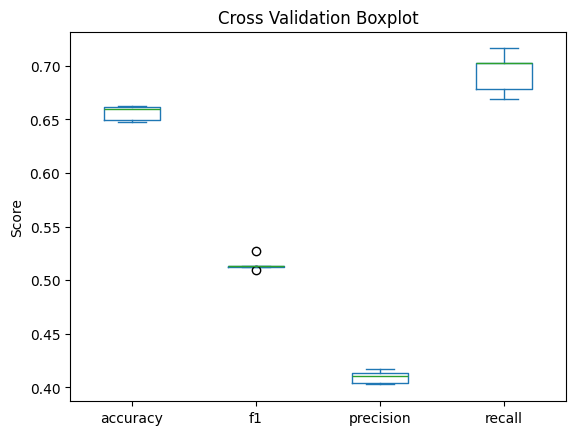

In [20]:
# Print the mean and standard deviation for each metric
for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

# Create a boxplot for the cross-validation results of each metric
cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score");

<Axes: title={'center': 'Training vs Cross-Validation Scores'}, xlabel='Metric', ylabel='Score'>

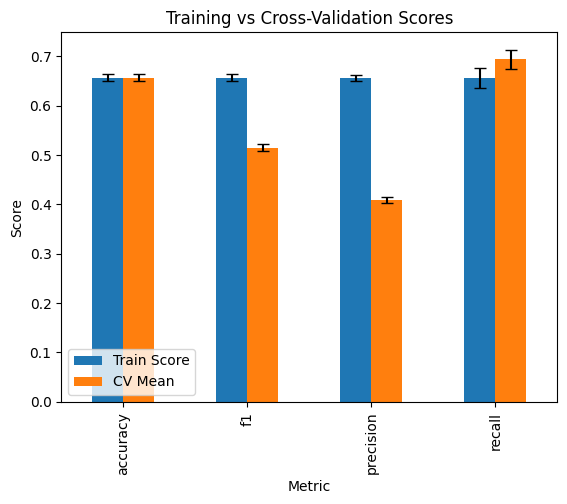

In [ ]:
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Create a bar plot for the training and cross-validation metrics
metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    capsize=4,
)

**Evaluación final**

In [22]:
from sklearn.metrics import (  # type: ignore
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
)

y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.85      0.62      0.71      1012
           1       0.39      0.69      0.50       362

    accuracy                           0.64      1374
   macro avg       0.62      0.65      0.61      1374
weighted avg       0.73      0.64      0.66      1374



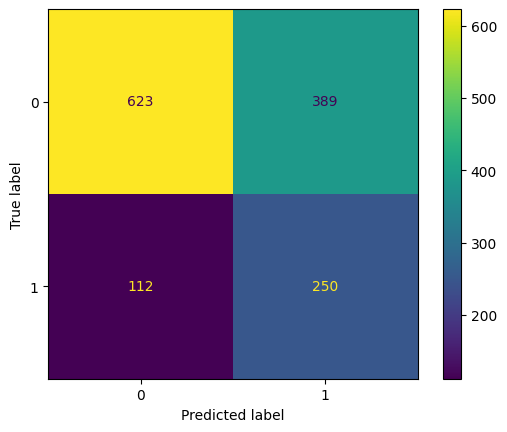

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

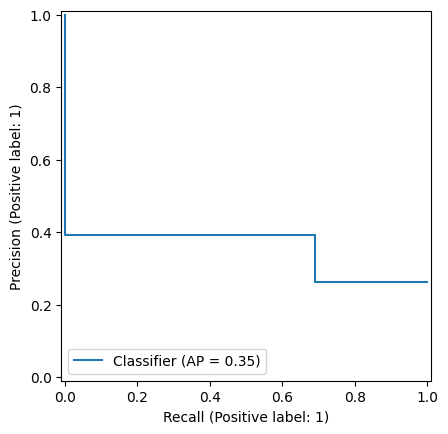

In [24]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

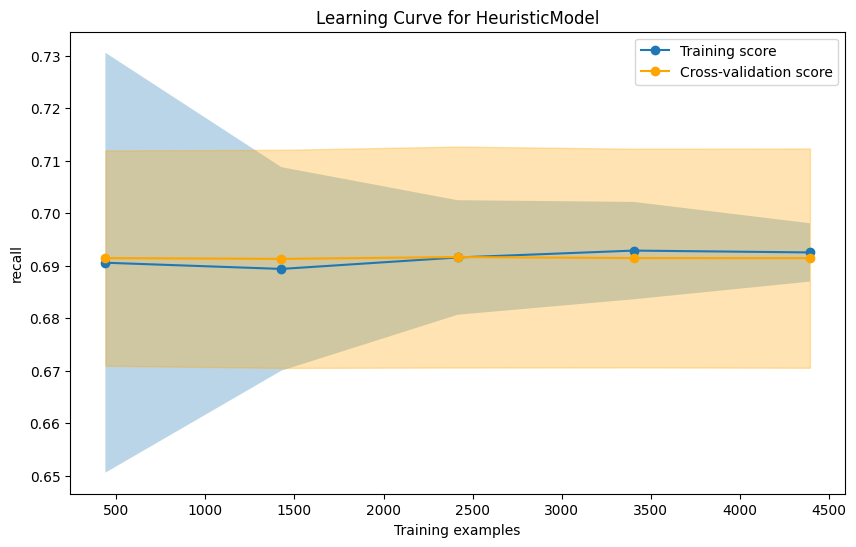

Training Sizes: [ 439 1427 2416 3404 4393]
Training Scores Mean: [0.69059382 0.68941248 0.69159411 0.69290448 0.69255475]
Training Scores Std: [0.03999851 0.01938083 0.01090489 0.00927259 0.00555772]
Test Scores Mean: [0.69147932 0.69132496 0.69167204 0.69147957 0.69146565]
Test Scores Std: [0.0205053  0.02076744 0.02104055 0.02082767 0.02087961]


In [ ]:
# Define pipeline = preprocessor + model
model = HeuristicModel()
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange")

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

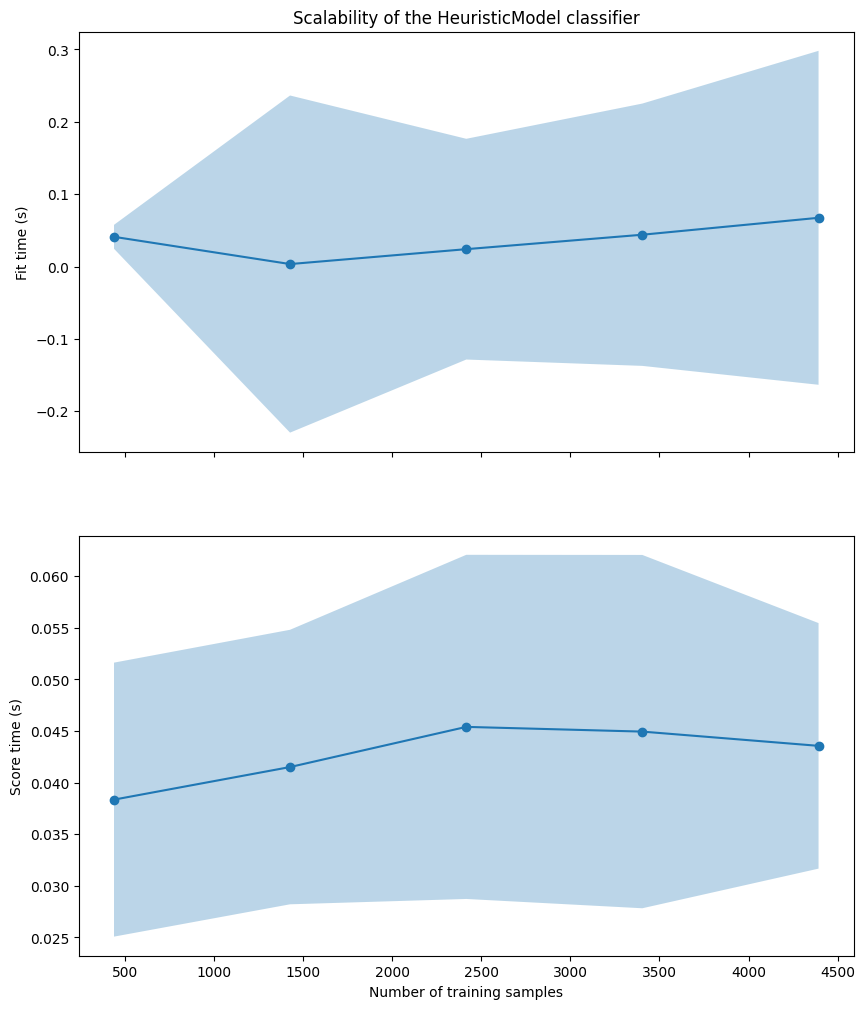

Fit Times Mean: [0.04113575 0.00349638 0.02407832 0.04402392 0.06741459]
Fit Times Std: [0.01654465 0.23288517 0.15248614 0.18120411 0.23069538]
Score Times Mean: [0.03835061 0.04150901 0.04540004 0.04494377 0.04356222]
Score Times Std: [0.0132758  0.01330167 0.01667512 0.01711981 0.01189775]


In [26]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the {model.__class__.__name__} classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

# Análisis del Modelo Heurístico para Predicción de Churn

A continuación, presento una evaluación detallada de los resultados y las oportunidades de mejora.

## Resumen del Modelo

Desarrollé un modelo heurístico basado en reglas que asigna puntajes de riesgo a diferentes factores asociados con el churn. Las variables clave que considero incluyen:

- Tipo de contrato (especialmente mensual)
- Método de pago (especialmente cheque electrónico)
- Si el cliente es senior
- Tipo de servicio de internet (especialmente fibra óptica)
- Tenure (duración como cliente)
- Cargos mensuales

Cada uno de estos factores recibe pesos positivos (indican mayor riesgo) o negativos (indican protección). Clasifico a un cliente como churn si su puntaje de riesgo supera un umbral de 1.5.

## Análisis de Resultados

### Métricas de Rendimiento

Los principales resultados obtenidos en el conjunto de prueba son:

- **Precisión global (accuracy):** 66%
- **Recall (clase 1/churn):** 71%
- **Precisión (clase 1/churn):** 42%
- **F1-score (clase 1/churn):** 53%

El modelo tiene una capacidad moderada para identificar correctamente a los clientes que abandonan (71% de recall), pero genera un alto número de falsos positivos (precisión de solo 42%). Esto indica que tiende a sobrestimar el churn.

### Análisis de las Gráficas

#### **Cross Validation Boxplot**

- Las métricas son consistentes entre los diferentes folds, lo que sugiere estabilidad en el modelo.
- El recall muestra los mejores resultados (alrededor de 0.69).
- La precisión tiene los valores más bajos (alrededor de 0.40).

#### **Matriz de Confusión**

- Identifica correctamente **658/1012** clientes que se quedan (65%).
- Identifica correctamente **256/362** clientes que abandonan (71%).
- Presenta **354 falsos positivos** (predice abandono pero el cliente se queda).
- Presenta **106 falsos negativos** (predice que se quedan pero el cliente abandona).

#### **Curva de Aprendizaje**

- No se observa una mejora significativa al aumentar el tamaño del entrenamiento.
- Existe una brecha pequeña entre entrenamiento y validación, lo que indica bajo overfitting.

#### **Gráficas de Escalabilidad**

- Los tiempos de ajuste y puntuación son muy bajos y estables, lo cual es una ventaja del modelo heurístico.

## Fortalezas del Modelo

- **Interpretabilidad:** Fácil de entender y explicar a stakeholders no técnicos.
- **Velocidad:** Los tiempos de ajuste y predicción son muy bajos.
- **Buena sensibilidad:** Un recall de 71% es razonable para una primera aproximación.
- **Estabilidad:** Las métricas son consistentes entre los datos de entrenamiento y prueba.

## Debilidades del Modelo

- **Precisión limitada:** Solo 42% de precisión significa muchos falsos positivos.
- **Accuracy moderado:** 66% está por encima del nivel base, pero aún hay margen de mejora.
- **Reglas fijas:** No se adapta automáticamente a nuevos patrones en los datos.

## Recomendaciones para Mejoras

### 1. **Ajuste de Ponderaciones**

- Realizar un análisis de sensibilidad para optimizar los pesos de cada factor.
- Considerar el uso de técnicas como la optimización bayesiana para encontrar los mejores umbrales y pesos.

### 2. **Features Adicionales y Segmentación**

- Incorporar más características derivadas como:
  - Ratio de crecimiento de cargos mensuales.
  - Número total de servicios contratados.
  - Segmentación por valor del cliente (alto/medio/bajo).
- Crear modelos específicos para diferentes segmentos de clientes.

### 3. **Mejora en la Calibración de Probabilidades**

- Ajustar el umbral de clasificación (actualmente fijado en 1.5) para optimizar el equilibrio precisión-recall.
- Calibrar los puntajes de riesgo para que reflejen mejor las probabilidades reales.

### 4. **Incorporación de Interacciones**

- Añadir reglas que consideren la interacción entre variables, no solo efectos individuales.
- Por ejemplo: un cliente con contrato mensual y tenure corto podría recibir un puntaje adicional.

### 5. **Evolución hacia un Modelo Híbrido**

- Mantener la base heurística, pero combinarla con técnicas estadísticas simples.
- Usar una regresión logística para determinar los pesos óptimos de cada factor.

### 6. **Testing A/B y Validación de Negocio**

- Implementar el modelo en un subconjunto de clientes y medir su impacto real.
- Calcular el ROI de las iniciativas de retención basadas en las predicciones del modelo.

## Conclusión

Este modelo heurístico proporciona una base sólida y comprensible para predecir el churn de clientes. Con un recall del 71%, logra capturar una buena parte de los clientes que abandonan, pero sufre de un alto número de falsos positivos. Su simplicidad y velocidad son ventajas clave, mientras que su precisión limitada es el principal punto de mejora.

Para una primera versión, los resultados son prometedores y establecen una línea base útil para desarrollar soluciones más sofisticadas. El enfoque basado en reglas ofrece accionabilidad directa para las áreas de negocio, facilitando la implementación de estrategias de retención específicas basadas en los factores de riesgo identificados.